#**1. 캐글 산단테르 고객 만족 예측(4.8장)**

- XGBoost와 LightGBM을 활용해 예측
- 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부 예측
- 클래스 레이블 명 : TARGET
  - 1: 불만을 가진 고객
  - 0: 만족한 고객
- 모델 성능 평가 : ROC_AU(ROC 곡선 영역)
  - 대부분 만족이고 불만족인 데이터는 일부일 것이기 때문에 정확도 수치보다 ROC-AU가 더 적합

##**1) 데이터 전처리**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df=pd.read_csv("/content/drive/MyDrive/Euron7_ML/data/train_santander.csv",encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [3]:
#전체 데이터에서 만족과 불만족 비율 알아보기 : 레이블인 Target 속성 값의 분포
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
#각 피처 값의 분포 확인
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


- var3 칼럼의 min값이 -999999 : NaN값이나 특정 예외 값을 -999999로 변환했을 것임.
  - 편차가 너무 심함으로 가장 값이 많은 2로 변환
- ID 피처는 단순 식별자이므로 피처 드롭
- 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 저장

In [4]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1, inplace=True)

#피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


<ipython-input-4-eb95136ef785>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cust_df['var3'].replace(-999999,2,inplace=True)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features,y_labels,
                                                    test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0},테스트 세트 Shape{1}'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369),테스트 세트 Shape(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


##**2) XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

In [7]:
import xgboost
print(xgboost.__version__)

1.5.0


/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [14]:
pip install xgboost==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.2
    Uninstalling xgboost-2.1.2:
      Successfully uninstalled xgboost-2.1.2


In [1]:
import xgboost
print(xgboost.__version__)

1.5.0


In [10]:
import pandas as pd
print(pd.__version__)


2.2.2


In [13]:
pip install pandas==1.5.3  # 예시로 1.5.3 버전으로 다운그레이드


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimators는 500으로, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88072	validation_1-auc:0.84117
[16]	validation_0-auc:0.88238	validation_1-auc:0.84101
[17]	validation_0-auc:0.88354	validation_1-auc:0.84071
[18]	validation_0-au

In [10]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf=XGBClassifier(n_estimators=100)

params={
    'max_depth':[5,7],
    'min_child_weight':[1,3],
    'colsample_bytree':[0.5,0.75]
}

#cv는 3으로 지정
gridcv=GridSearchCV(xgb_clf,param_grid=params,cv=3)
gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric="auc",
           eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridsearchCV 최적 파라미터 :',gridcv.best_params_)

xgb_roc_score=roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80289	validation_1-auc:0.80420
[1]	validation_0-auc:0.80678	validation_1-auc:0.80892
[2]	validation_0-auc:0.82161	validation_1-auc:0.81979
[3]	validation_0-auc:0.82876	validation_1-auc:0.82509
[4]	validation_0-auc:0.83227	validation_1-auc:0.82868
[5]	validation_0-auc:0.83179	validation_1-auc:0.82649
[6]	validation_0-auc:0.82661	validation_1-auc:0.81879
[7]	validation_0-auc:0.83687	validation_1-auc:0.82901
[8]	validation_0-auc:0.84136	validation_1-auc:0.83545
[9]	validation_0-auc:0.84304	validation_1-auc:0.83301
[10]	validation_0-auc:0.84221	validation_1-auc:0.83210
[11]	validation_0-auc:0.84723	validation_1-auc:0.83457
[12]	validation_0-auc:0.85186	validation_1-auc:0.83740
[13]	validation_0-auc:0.85372	validation_1-auc:0.83434
[14]	validation_0-auc:0.85631	validation_1-auc:0.83641
[15]	validation_0-auc:0.85719	validation_1-auc:0.83617
[16]	validation_0-auc:0.85907	validation_1-auc:0.83443
[17]	validation_0-auc:0.86100	validation_1-auc:0.83417
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80699	validation_1-auc:0.80599
[1]	validation_0-auc:0.81029	validation_1-auc:0.81309
[2]	validation_0-auc:0.82504	validation_1-auc:0.82148
[3]	validation_0-auc:0.83183	validation_1-auc:0.82497
[4]	validation_0-auc:0.83585	validation_1-auc:0.82786
[5]	validation_0-auc:0.83864	validation_1-auc:0.83222
[6]	validation_0-auc:0.83483	validation_1-auc:0.83054
[7]	validation_0-auc:0.84061	validation_1-auc:0.83365
[8]	validation_0-auc:0.84452	validation_1-auc:0.83729
[9]	validation_0-auc:0.84411	validation_1-auc:0.83520
[10]	validation_0-auc:0.84329	validation_1-auc:0.83367
[11]	validation_0-auc:0.84914	validation_1-auc:0.83676
[12]	validation_0-auc:0.85414	validation_1-auc:0.83983
[13]	validation_0-auc:0.85570	validation_1-auc:0.83826
[14]	validation_0-auc:0.85887	validation_1-auc:0.83916
[15]	validation_0-auc:0.85987	validation_1-auc:0.84004
[16]	validation_0-auc:0.86042	validation_1-auc:0.84034
[17]	validation_0-auc:0.86156	validation_1-auc:0.84030
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81203	validation_1-auc:0.80951
[1]	validation_0-auc:0.81450	validation_1-auc:0.81585
[2]	validation_0-auc:0.82678	validation_1-auc:0.82141
[3]	validation_0-auc:0.82958	validation_1-auc:0.82431
[4]	validation_0-auc:0.83590	validation_1-auc:0.82659
[5]	validation_0-auc:0.83743	validation_1-auc:0.82696
[6]	validation_0-auc:0.83508	validation_1-auc:0.82420
[7]	validation_0-auc:0.84130	validation_1-auc:0.82966
[8]	validation_0-auc:0.84500	validation_1-auc:0.83477
[9]	validation_0-auc:0.84551	validation_1-auc:0.83453
[10]	validation_0-auc:0.84494	validation_1-auc:0.83201
[11]	validation_0-auc:0.85031	validation_1-auc:0.83706
[12]	validation_0-auc:0.85489	validation_1-auc:0.83832
[13]	validation_0-auc:0.85636	validation_1-auc:0.83727
[14]	validation_0-auc:0.85874	validation_1-auc:0.83913
[15]	validation_0-auc:0.85980	validation_1-auc:0.83969
[16]	validation_0-auc:0.86061	validation_1-auc:0.83876
[17]	validation_0-auc:0.86171	validation_1-auc:0.83857
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80246	validation_1-auc:0.80463
[1]	validation_0-auc:0.80769	validation_1-auc:0.80995
[2]	validation_0-auc:0.82216	validation_1-auc:0.82059
[3]	validation_0-auc:0.82983	validation_1-auc:0.82797
[4]	validation_0-auc:0.83294	validation_1-auc:0.82964
[5]	validation_0-auc:0.83289	validation_1-auc:0.82807
[6]	validation_0-auc:0.82913	validation_1-auc:0.82282
[7]	validation_0-auc:0.83623	validation_1-auc:0.82949
[8]	validation_0-auc:0.84169	validation_1-auc:0.83424
[9]	validation_0-auc:0.84276	validation_1-auc:0.83206
[10]	validation_0-auc:0.84290	validation_1-auc:0.83209
[11]	validation_0-auc:0.84726	validation_1-auc:0.83490
[12]	validation_0-auc:0.85185	validation_1-auc:0.83765
[13]	validation_0-auc:0.85354	validation_1-auc:0.83497
[14]	validation_0-auc:0.85519	validation_1-auc:0.83661
[15]	validation_0-auc:0.85551	validation_1-auc:0.83619
[16]	validation_0-auc:0.85659	validation_1-auc:0.83520
[17]	validation_0-auc:0.85731	validation_1-auc:0.83493
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80418	validation_1-auc:0.81169
[1]	validation_0-auc:0.81174	validation_1-auc:0.81122
[2]	validation_0-auc:0.82946	validation_1-auc:0.82272
[3]	validation_0-auc:0.83495	validation_1-auc:0.82851
[4]	validation_0-auc:0.83721	validation_1-auc:0.82887
[5]	validation_0-auc:0.83847	validation_1-auc:0.83206
[6]	validation_0-auc:0.83511	validation_1-auc:0.83097
[7]	validation_0-auc:0.84116	validation_1-auc:0.83427
[8]	validation_0-auc:0.84533	validation_1-auc:0.83959
[9]	validation_0-auc:0.84475	validation_1-auc:0.83715
[10]	validation_0-auc:0.84396	validation_1-auc:0.83646
[11]	validation_0-auc:0.84838	validation_1-auc:0.83860
[12]	validation_0-auc:0.85327	validation_1-auc:0.84141
[13]	validation_0-auc:0.85384	validation_1-auc:0.83952
[14]	validation_0-auc:0.85744	validation_1-auc:0.84166
[15]	validation_0-auc:0.85825	validation_1-auc:0.84222
[16]	validation_0-auc:0.85867	validation_1-auc:0.84194
[17]	validation_0-auc:0.85910	validation_1-auc:0.84171
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81098	validation_1-auc:0.80916
[1]	validation_0-auc:0.81358	validation_1-auc:0.81312
[2]	validation_0-auc:0.82606	validation_1-auc:0.82075
[3]	validation_0-auc:0.83126	validation_1-auc:0.82413
[4]	validation_0-auc:0.83431	validation_1-auc:0.82739
[5]	validation_0-auc:0.83669	validation_1-auc:0.82762
[6]	validation_0-auc:0.83388	validation_1-auc:0.82326
[7]	validation_0-auc:0.83882	validation_1-auc:0.82781
[8]	validation_0-auc:0.84310	validation_1-auc:0.83488
[9]	validation_0-auc:0.84383	validation_1-auc:0.83609
[10]	validation_0-auc:0.84300	validation_1-auc:0.83454
[11]	validation_0-auc:0.84807	validation_1-auc:0.83810
[12]	validation_0-auc:0.85239	validation_1-auc:0.84034
[13]	validation_0-auc:0.85437	validation_1-auc:0.83857
[14]	validation_0-auc:0.85624	validation_1-auc:0.83976
[15]	validation_0-auc:0.85748	validation_1-auc:0.83981
[16]	validation_0-auc:0.85830	validation_1-auc:0.83989
[17]	validation_0-auc:0.85956	validation_1-auc:0.83887
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80902	validation_1-auc:0.80594
[1]	validation_0-auc:0.80814	validation_1-auc:0.80463
[2]	validation_0-auc:0.82929	validation_1-auc:0.82254
[3]	validation_0-auc:0.83621	validation_1-auc:0.82625
[4]	validation_0-auc:0.83964	validation_1-auc:0.82813
[5]	validation_0-auc:0.84237	validation_1-auc:0.82613
[6]	validation_0-auc:0.84139	validation_1-auc:0.82316
[7]	validation_0-auc:0.84976	validation_1-auc:0.82936
[8]	validation_0-auc:0.85363	validation_1-auc:0.83274
[9]	validation_0-auc:0.85616	validation_1-auc:0.82987
[10]	validation_0-auc:0.85494	validation_1-auc:0.82878
[11]	validation_0-auc:0.86352	validation_1-auc:0.83263
[12]	validation_0-auc:0.86903	validation_1-auc:0.83413
[13]	validation_0-auc:0.87059	validation_1-auc:0.83155
[14]	validation_0-auc:0.87381	validation_1-auc:0.83338
[15]	validation_0-auc:0.87434	validation_1-auc:0.83100
[16]	validation_0-auc:0.87539	validation_1-auc:0.83110
[17]	validation_0-auc:0.87742	validation_1-auc:0.82964
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80941	validation_1-auc:0.80686
[1]	validation_0-auc:0.81556	validation_1-auc:0.81361
[2]	validation_0-auc:0.83096	validation_1-auc:0.82315
[3]	validation_0-auc:0.83933	validation_1-auc:0.82851
[4]	validation_0-auc:0.84416	validation_1-auc:0.83167
[5]	validation_0-auc:0.84872	validation_1-auc:0.83320
[6]	validation_0-auc:0.84648	validation_1-auc:0.82990
[7]	validation_0-auc:0.85307	validation_1-auc:0.83396
[8]	validation_0-auc:0.85680	validation_1-auc:0.83723
[9]	validation_0-auc:0.85902	validation_1-auc:0.83808
[10]	validation_0-auc:0.85868	validation_1-auc:0.83643
[11]	validation_0-auc:0.86500	validation_1-auc:0.83869
[12]	validation_0-auc:0.87073	validation_1-auc:0.84082
[13]	validation_0-auc:0.87242	validation_1-auc:0.83814
[14]	validation_0-auc:0.87684	validation_1-auc:0.84077
[15]	validation_0-auc:0.87784	validation_1-auc:0.84085
[16]	validation_0-auc:0.87876	validation_1-auc:0.83983
[17]	validation_0-auc:0.87990	validation_1-auc:0.83837
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81702	validation_1-auc:0.81220
[1]	validation_0-auc:0.82046	validation_1-auc:0.81514
[2]	validation_0-auc:0.83453	validation_1-auc:0.82323
[3]	validation_0-auc:0.83849	validation_1-auc:0.82737
[4]	validation_0-auc:0.84346	validation_1-auc:0.82934
[5]	validation_0-auc:0.84713	validation_1-auc:0.83083
[6]	validation_0-auc:0.84430	validation_1-auc:0.82628
[7]	validation_0-auc:0.85255	validation_1-auc:0.83025
[8]	validation_0-auc:0.85662	validation_1-auc:0.83387
[9]	validation_0-auc:0.85863	validation_1-auc:0.83446
[10]	validation_0-auc:0.85883	validation_1-auc:0.83329
[11]	validation_0-auc:0.86666	validation_1-auc:0.83528
[12]	validation_0-auc:0.87214	validation_1-auc:0.83776
[13]	validation_0-auc:0.87499	validation_1-auc:0.83590
[14]	validation_0-auc:0.87718	validation_1-auc:0.83829
[15]	validation_0-auc:0.87780	validation_1-auc:0.83772
[16]	validation_0-auc:0.87852	validation_1-auc:0.83749
[17]	validation_0-auc:0.88026	validation_1-auc:0.83555
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80956	validation_1-auc:0.80714
[1]	validation_0-auc:0.81193	validation_1-auc:0.80854
[2]	validation_0-auc:0.82506	validation_1-auc:0.81970
[3]	validation_0-auc:0.83477	validation_1-auc:0.82709
[4]	validation_0-auc:0.83821	validation_1-auc:0.82847
[5]	validation_0-auc:0.84212	validation_1-auc:0.82840
[6]	validation_0-auc:0.83981	validation_1-auc:0.82187
[7]	validation_0-auc:0.84643	validation_1-auc:0.82964
[8]	validation_0-auc:0.85106	validation_1-auc:0.83246
[9]	validation_0-auc:0.85266	validation_1-auc:0.83022
[10]	validation_0-auc:0.85201	validation_1-auc:0.82886
[11]	validation_0-auc:0.85929	validation_1-auc:0.83305
[12]	validation_0-auc:0.86420	validation_1-auc:0.83632
[13]	validation_0-auc:0.86580	validation_1-auc:0.83527
[14]	validation_0-auc:0.86838	validation_1-auc:0.83751
[15]	validation_0-auc:0.86916	validation_1-auc:0.83644
[16]	validation_0-auc:0.86962	validation_1-auc:0.83589
[17]	validation_0-auc:0.87134	validation_1-auc:0.83500
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80761	validation_1-auc:0.81297
[1]	validation_0-auc:0.81426	validation_1-auc:0.81464
[2]	validation_0-auc:0.83333	validation_1-auc:0.82937
[3]	validation_0-auc:0.83932	validation_1-auc:0.83359
[4]	validation_0-auc:0.84334	validation_1-auc:0.83390
[5]	validation_0-auc:0.84684	validation_1-auc:0.83404
[6]	validation_0-auc:0.84426	validation_1-auc:0.83247
[7]	validation_0-auc:0.84963	validation_1-auc:0.83651
[8]	validation_0-auc:0.85390	validation_1-auc:0.84200
[9]	validation_0-auc:0.85566	validation_1-auc:0.84119
[10]	validation_0-auc:0.85553	validation_1-auc:0.83994
[11]	validation_0-auc:0.86125	validation_1-auc:0.84109
[12]	validation_0-auc:0.86665	validation_1-auc:0.84226
[13]	validation_0-auc:0.86778	validation_1-auc:0.84071
[14]	validation_0-auc:0.87188	validation_1-auc:0.84338
[15]	validation_0-auc:0.87285	validation_1-auc:0.84417
[16]	validation_0-auc:0.87300	validation_1-auc:0.84269
[17]	validation_0-auc:0.87368	validation_1-auc:0.84204
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81604	validation_1-auc:0.81234
[1]	validation_0-auc:0.82253	validation_1-auc:0.81400
[2]	validation_0-auc:0.83498	validation_1-auc:0.82366
[3]	validation_0-auc:0.84183	validation_1-auc:0.82843
[4]	validation_0-auc:0.84413	validation_1-auc:0.82954
[5]	validation_0-auc:0.84630	validation_1-auc:0.82708
[6]	validation_0-auc:0.84502	validation_1-auc:0.82381
[7]	validation_0-auc:0.85257	validation_1-auc:0.82814
[8]	validation_0-auc:0.85582	validation_1-auc:0.83553
[9]	validation_0-auc:0.85747	validation_1-auc:0.83650
[10]	validation_0-auc:0.85661	validation_1-auc:0.83364
[11]	validation_0-auc:0.86296	validation_1-auc:0.83958
[12]	validation_0-auc:0.86754	validation_1-auc:0.84099
[13]	validation_0-auc:0.86876	validation_1-auc:0.83850
[14]	validation_0-auc:0.87077	validation_1-auc:0.84079
[15]	validation_0-auc:0.87242	validation_1-auc:0.84106
[16]	validation_0-auc:0.87328	validation_1-auc:0.83940
[17]	validation_0-auc:0.87409	validation_1-auc:0.83849
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80593	validation_1-auc:0.80898
[1]	validation_0-auc:0.80944	validation_1-auc:0.80802
[2]	validation_0-auc:0.82441	validation_1-auc:0.82007
[3]	validation_0-auc:0.83164	validation_1-auc:0.82390
[4]	validation_0-auc:0.83773	validation_1-auc:0.82921
[5]	validation_0-auc:0.83842	validation_1-auc:0.83047
[6]	validation_0-auc:0.84104	validation_1-auc:0.83226
[7]	validation_0-auc:0.84469	validation_1-auc:0.83537
[8]	validation_0-auc:0.84683	validation_1-auc:0.83548
[9]	validation_0-auc:0.84814	validation_1-auc:0.83619
[10]	validation_0-auc:0.84998	validation_1-auc:0.83683
[11]	validation_0-auc:0.85145	validation_1-auc:0.83648
[12]	validation_0-auc:0.85391	validation_1-auc:0.83602
[13]	validation_0-auc:0.85621	validation_1-auc:0.83614
[14]	validation_0-auc:0.85711	validation_1-auc:0.83651
[15]	validation_0-auc:0.85911	validation_1-auc:0.83675
[16]	validation_0-auc:0.86083	validation_1-auc:0.83563
[17]	validation_0-auc:0.86138	validation_1-auc:0.83521
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80863	validation_1-auc:0.80010
[1]	validation_0-auc:0.80571	validation_1-auc:0.80437
[2]	validation_0-auc:0.82796	validation_1-auc:0.82018
[3]	validation_0-auc:0.83445	validation_1-auc:0.82663
[4]	validation_0-auc:0.83787	validation_1-auc:0.82864
[5]	validation_0-auc:0.84117	validation_1-auc:0.83429
[6]	validation_0-auc:0.84465	validation_1-auc:0.83836
[7]	validation_0-auc:0.84676	validation_1-auc:0.83896
[8]	validation_0-auc:0.84853	validation_1-auc:0.83854
[9]	validation_0-auc:0.85047	validation_1-auc:0.83875
[10]	validation_0-auc:0.85238	validation_1-auc:0.83996
[11]	validation_0-auc:0.85450	validation_1-auc:0.83884
[12]	validation_0-auc:0.85576	validation_1-auc:0.84019
[13]	validation_0-auc:0.85703	validation_1-auc:0.84096
[14]	validation_0-auc:0.85943	validation_1-auc:0.84124
[15]	validation_0-auc:0.86088	validation_1-auc:0.84081
[16]	validation_0-auc:0.86188	validation_1-auc:0.84113
[17]	validation_0-auc:0.86250	validation_1-auc:0.84169
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.82051	validation_1-auc:0.81705
[1]	validation_0-auc:0.81489	validation_1-auc:0.81463
[2]	validation_0-auc:0.82613	validation_1-auc:0.82392
[3]	validation_0-auc:0.83159	validation_1-auc:0.82688
[4]	validation_0-auc:0.83529	validation_1-auc:0.82743
[5]	validation_0-auc:0.84072	validation_1-auc:0.83137
[6]	validation_0-auc:0.84302	validation_1-auc:0.83442
[7]	validation_0-auc:0.84511	validation_1-auc:0.83555
[8]	validation_0-auc:0.84587	validation_1-auc:0.83638
[9]	validation_0-auc:0.84812	validation_1-auc:0.83673
[10]	validation_0-auc:0.85143	validation_1-auc:0.83526
[11]	validation_0-auc:0.85397	validation_1-auc:0.83620
[12]	validation_0-auc:0.85616	validation_1-auc:0.83763
[13]	validation_0-auc:0.85783	validation_1-auc:0.83704
[14]	validation_0-auc:0.85973	validation_1-auc:0.83846
[15]	validation_0-auc:0.86155	validation_1-auc:0.83830
[16]	validation_0-auc:0.86279	validation_1-auc:0.83844
[17]	validation_0-auc:0.86419	validation_1-auc:0.83895
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80803	validation_1-auc:0.80806
[1]	validation_0-auc:0.80888	validation_1-auc:0.80894
[2]	validation_0-auc:0.82405	validation_1-auc:0.81945
[3]	validation_0-auc:0.83156	validation_1-auc:0.82609
[4]	validation_0-auc:0.83401	validation_1-auc:0.82772
[5]	validation_0-auc:0.83658	validation_1-auc:0.82950
[6]	validation_0-auc:0.84047	validation_1-auc:0.83059
[7]	validation_0-auc:0.84358	validation_1-auc:0.83186
[8]	validation_0-auc:0.84541	validation_1-auc:0.83323
[9]	validation_0-auc:0.84653	validation_1-auc:0.83440
[10]	validation_0-auc:0.84920	validation_1-auc:0.83548
[11]	validation_0-auc:0.85030	validation_1-auc:0.83627
[12]	validation_0-auc:0.85268	validation_1-auc:0.83664
[13]	validation_0-auc:0.85483	validation_1-auc:0.83676
[14]	validation_0-auc:0.85628	validation_1-auc:0.83643
[15]	validation_0-auc:0.85783	validation_1-auc:0.83561
[16]	validation_0-auc:0.85834	validation_1-auc:0.83599
[17]	validation_0-auc:0.85875	validation_1-auc:0.83658
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.80906	validation_1-auc:0.80435
[1]	validation_0-auc:0.80610	validation_1-auc:0.80703
[2]	validation_0-auc:0.82830	validation_1-auc:0.82098
[3]	validation_0-auc:0.83657	validation_1-auc:0.82669
[4]	validation_0-auc:0.83911	validation_1-auc:0.82849
[5]	validation_0-auc:0.84163	validation_1-auc:0.83122
[6]	validation_0-auc:0.84566	validation_1-auc:0.83619
[7]	validation_0-auc:0.84720	validation_1-auc:0.83653
[8]	validation_0-auc:0.84844	validation_1-auc:0.83525
[9]	validation_0-auc:0.84959	validation_1-auc:0.83672
[10]	validation_0-auc:0.85155	validation_1-auc:0.83775
[11]	validation_0-auc:0.85323	validation_1-auc:0.83779
[12]	validation_0-auc:0.85457	validation_1-auc:0.83858
[13]	validation_0-auc:0.85554	validation_1-auc:0.83864
[14]	validation_0-auc:0.85654	validation_1-auc:0.83865
[15]	validation_0-auc:0.85860	validation_1-auc:0.83784
[16]	validation_0-auc:0.85972	validation_1-auc:0.83823
[17]	validation_0-auc:0.86068	validation_1-auc:0.83797
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81882	validation_1-auc:0.81739
[1]	validation_0-auc:0.81386	validation_1-auc:0.81337
[2]	validation_0-auc:0.82661	validation_1-auc:0.82334
[3]	validation_0-auc:0.83557	validation_1-auc:0.82907
[4]	validation_0-auc:0.83892	validation_1-auc:0.83167
[5]	validation_0-auc:0.84144	validation_1-auc:0.83105
[6]	validation_0-auc:0.84403	validation_1-auc:0.83359
[7]	validation_0-auc:0.84648	validation_1-auc:0.83417
[8]	validation_0-auc:0.84841	validation_1-auc:0.83581
[9]	validation_0-auc:0.84876	validation_1-auc:0.83593
[10]	validation_0-auc:0.85065	validation_1-auc:0.83624
[11]	validation_0-auc:0.85204	validation_1-auc:0.83676
[12]	validation_0-auc:0.85449	validation_1-auc:0.83495
[13]	validation_0-auc:0.85520	validation_1-auc:0.83583
[14]	validation_0-auc:0.85682	validation_1-auc:0.83720
[15]	validation_0-auc:0.85847	validation_1-auc:0.83743
[16]	validation_0-auc:0.85930	validation_1-auc:0.83756
[17]	validation_0-auc:0.86089	validation_1-auc:0.83842
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81573	validation_1-auc:0.81067
[1]	validation_0-auc:0.81402	validation_1-auc:0.80774
[2]	validation_0-auc:0.82912	validation_1-auc:0.81864
[3]	validation_0-auc:0.83834	validation_1-auc:0.82490
[4]	validation_0-auc:0.84340	validation_1-auc:0.82924
[5]	validation_0-auc:0.84800	validation_1-auc:0.83252
[6]	validation_0-auc:0.85152	validation_1-auc:0.83473
[7]	validation_0-auc:0.85737	validation_1-auc:0.83466
[8]	validation_0-auc:0.86002	validation_1-auc:0.83343
[9]	validation_0-auc:0.86333	validation_1-auc:0.83595
[10]	validation_0-auc:0.86764	validation_1-auc:0.83618
[11]	validation_0-auc:0.87055	validation_1-auc:0.83591
[12]	validation_0-auc:0.87303	validation_1-auc:0.83511
[13]	validation_0-auc:0.87531	validation_1-auc:0.83573
[14]	validation_0-auc:0.87644	validation_1-auc:0.83532
[15]	validation_0-auc:0.87864	validation_1-auc:0.83346
[16]	validation_0-auc:0.87995	validation_1-auc:0.83380
[17]	validation_0-auc:0.88099	validation_1-auc:0.83336
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81428	validation_1-auc:0.80541
[1]	validation_0-auc:0.81563	validation_1-auc:0.81176
[2]	validation_0-auc:0.83592	validation_1-auc:0.82066
[3]	validation_0-auc:0.84379	validation_1-auc:0.82740
[4]	validation_0-auc:0.85017	validation_1-auc:0.83233
[5]	validation_0-auc:0.85384	validation_1-auc:0.83518
[6]	validation_0-auc:0.85918	validation_1-auc:0.83931
[7]	validation_0-auc:0.86245	validation_1-auc:0.83779
[8]	validation_0-auc:0.86419	validation_1-auc:0.83818
[9]	validation_0-auc:0.86613	validation_1-auc:0.83712
[10]	validation_0-auc:0.86934	validation_1-auc:0.83600
[11]	validation_0-auc:0.87184	validation_1-auc:0.83711
[12]	validation_0-auc:0.87415	validation_1-auc:0.83710
[13]	validation_0-auc:0.87715	validation_1-auc:0.83639
[14]	validation_0-auc:0.87866	validation_1-auc:0.83795
[15]	validation_0-auc:0.88108	validation_1-auc:0.83841
[16]	validation_0-auc:0.88357	validation_1-auc:0.83779
[17]	validation_0-auc:0.88460	validation_1-auc:0.83794
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.82448	validation_1-auc:0.81823
[1]	validation_0-auc:0.82212	validation_1-auc:0.81592
[2]	validation_0-auc:0.83464	validation_1-auc:0.82639
[3]	validation_0-auc:0.84121	validation_1-auc:0.82994
[4]	validation_0-auc:0.84804	validation_1-auc:0.83439
[5]	validation_0-auc:0.85362	validation_1-auc:0.83315
[6]	validation_0-auc:0.85620	validation_1-auc:0.83630
[7]	validation_0-auc:0.86025	validation_1-auc:0.83581
[8]	validation_0-auc:0.86252	validation_1-auc:0.83743
[9]	validation_0-auc:0.86649	validation_1-auc:0.83647
[10]	validation_0-auc:0.87101	validation_1-auc:0.83606
[11]	validation_0-auc:0.87346	validation_1-auc:0.83743
[12]	validation_0-auc:0.87701	validation_1-auc:0.83809
[13]	validation_0-auc:0.88044	validation_1-auc:0.83779
[14]	validation_0-auc:0.88134	validation_1-auc:0.83869
[15]	validation_0-auc:0.88293	validation_1-auc:0.83977
[16]	validation_0-auc:0.88458	validation_1-auc:0.83955
[17]	validation_0-auc:0.88561	validation_1-auc:0.83952
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81642	validation_1-auc:0.81216
[1]	validation_0-auc:0.81467	validation_1-auc:0.81133
[2]	validation_0-auc:0.82902	validation_1-auc:0.82239
[3]	validation_0-auc:0.83775	validation_1-auc:0.82795
[4]	validation_0-auc:0.84354	validation_1-auc:0.83096
[5]	validation_0-auc:0.84790	validation_1-auc:0.83441
[6]	validation_0-auc:0.85080	validation_1-auc:0.83508
[7]	validation_0-auc:0.85454	validation_1-auc:0.83765
[8]	validation_0-auc:0.85680	validation_1-auc:0.83712
[9]	validation_0-auc:0.85991	validation_1-auc:0.83639
[10]	validation_0-auc:0.86257	validation_1-auc:0.83788
[11]	validation_0-auc:0.86486	validation_1-auc:0.83696
[12]	validation_0-auc:0.86743	validation_1-auc:0.83751
[13]	validation_0-auc:0.86907	validation_1-auc:0.83692
[14]	validation_0-auc:0.87014	validation_1-auc:0.83647
[15]	validation_0-auc:0.87204	validation_1-auc:0.83610
[16]	validation_0-auc:0.87313	validation_1-auc:0.83591
[17]	validation_0-auc:0.87401	validation_1-auc:0.83522
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81195	validation_1-auc:0.80615
[1]	validation_0-auc:0.81510	validation_1-auc:0.81289
[2]	validation_0-auc:0.83475	validation_1-auc:0.82645
[3]	validation_0-auc:0.84423	validation_1-auc:0.83140
[4]	validation_0-auc:0.84952	validation_1-auc:0.83408
[5]	validation_0-auc:0.85316	validation_1-auc:0.83493
[6]	validation_0-auc:0.85713	validation_1-auc:0.83850
[7]	validation_0-auc:0.85924	validation_1-auc:0.83793
[8]	validation_0-auc:0.86016	validation_1-auc:0.83809
[9]	validation_0-auc:0.86307	validation_1-auc:0.83816
[10]	validation_0-auc:0.86572	validation_1-auc:0.83931
[11]	validation_0-auc:0.86748	validation_1-auc:0.83981
[12]	validation_0-auc:0.87020	validation_1-auc:0.83906
[13]	validation_0-auc:0.87271	validation_1-auc:0.84018
[14]	validation_0-auc:0.87372	validation_1-auc:0.84127
[15]	validation_0-auc:0.87558	validation_1-auc:0.84117
[16]	validation_0-auc:0.87631	validation_1-auc:0.84078
[17]	validation_0-auc:0.87671	validation_1-auc:0.84143
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.82218	validation_1-auc:0.81819
[1]	validation_0-auc:0.82120	validation_1-auc:0.81682
[2]	validation_0-auc:0.83459	validation_1-auc:0.82497
[3]	validation_0-auc:0.84312	validation_1-auc:0.82940
[4]	validation_0-auc:0.84793	validation_1-auc:0.83178
[5]	validation_0-auc:0.85339	validation_1-auc:0.83203
[6]	validation_0-auc:0.85638	validation_1-auc:0.83512
[7]	validation_0-auc:0.86082	validation_1-auc:0.83537
[8]	validation_0-auc:0.86250	validation_1-auc:0.83772
[9]	validation_0-auc:0.86569	validation_1-auc:0.83589
[10]	validation_0-auc:0.86855	validation_1-auc:0.83342
[11]	validation_0-auc:0.87104	validation_1-auc:0.83398
[12]	validation_0-auc:0.87268	validation_1-auc:0.83472
[13]	validation_0-auc:0.87476	validation_1-auc:0.83576
[14]	validation_0-auc:0.87520	validation_1-auc:0.83642
[15]	validation_0-auc:0.87568	validation_1-auc:0.83708
[16]	validation_0-auc:0.87706	validation_1-auc:0.83742
[17]	validation_0-auc:0.87815	validation_1-auc:0.83725
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.81270	validation_1-auc:0.81076
[1]	validation_0-auc:0.81820	validation_1-auc:0.81361
[2]	validation_0-auc:0.83353	validation_1-auc:0.83010
[3]	validation_0-auc:0.83823	validation_1-auc:0.83429
[4]	validation_0-auc:0.84125	validation_1-auc:0.83363
[5]	validation_0-auc:0.83979	validation_1-auc:0.83299
[6]	validation_0-auc:0.83796	validation_1-auc:0.83148
[7]	validation_0-auc:0.84384	validation_1-auc:0.83526
[8]	validation_0-auc:0.84676	validation_1-auc:0.83677
[9]	validation_0-auc:0.84731	validation_1-auc:0.83538
[10]	validation_0-auc:0.84726	validation_1-auc:0.83485
[11]	validation_0-auc:0.85252	validation_1-auc:0.84007
[12]	validation_0-auc:0.85677	validation_1-auc:0.84255
[13]	validation_0-auc:0.85820	validation_1-auc:0.84121
[14]	validation_0-auc:0.86100	validation_1-auc:0.84394
[15]	validation_0-auc:0.86248	validation_1-auc:0.84436
[16]	validation_0-auc:0.86370	validation_1-auc:0.84416
[17]	validation_0-auc:0.86532	validation_1-auc:0.84329
[18]	validation_0-au

In [11]:
#n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가
xgb_clf = XGBClassifier(n_estimators=1000,random_state=156,learning_rate=0.02,
                        max_depth=7,min_child_weight=1,colsample_bytree=0.75,
                        reg_alpha=0.03)

#성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future r

[0]	validation_0-auc:0.82311	validation_1-auc:0.81793
[1]	validation_0-auc:0.82585	validation_1-auc:0.81766
[2]	validation_0-auc:0.82950	validation_1-auc:0.81846
[3]	validation_0-auc:0.83162	validation_1-auc:0.82051
[4]	validation_0-auc:0.83561	validation_1-auc:0.82587
[5]	validation_0-auc:0.83587	validation_1-auc:0.82589
[6]	validation_0-auc:0.83628	validation_1-auc:0.82598
[7]	validation_0-auc:0.83755	validation_1-auc:0.82774
[8]	validation_0-auc:0.83871	validation_1-auc:0.82954
[9]	validation_0-auc:0.83983	validation_1-auc:0.83076
[10]	validation_0-auc:0.84033	validation_1-auc:0.83048
[11]	validation_0-auc:0.84065	validation_1-auc:0.83059
[12]	validation_0-auc:0.84057	validation_1-auc:0.82999
[13]	validation_0-auc:0.84096	validation_1-auc:0.82960
[14]	validation_0-auc:0.84173	validation_1-auc:0.83023
[15]	validation_0-auc:0.84222	validation_1-auc:0.83107
[16]	validation_0-auc:0.84260	validation_1-auc:0.83061
[17]	validation_0-auc:0.84297	validation_1-auc:0.83026
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_parallel_tree=1,
              predictor='auto', random_state=156, reg_alpha=0.03, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [12]:
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

ROC AUC:0.8451


- XGBoost가 GBM보단 빠르지만 GBM을 기반으로 하고 있어서 수행시간이 상당함

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

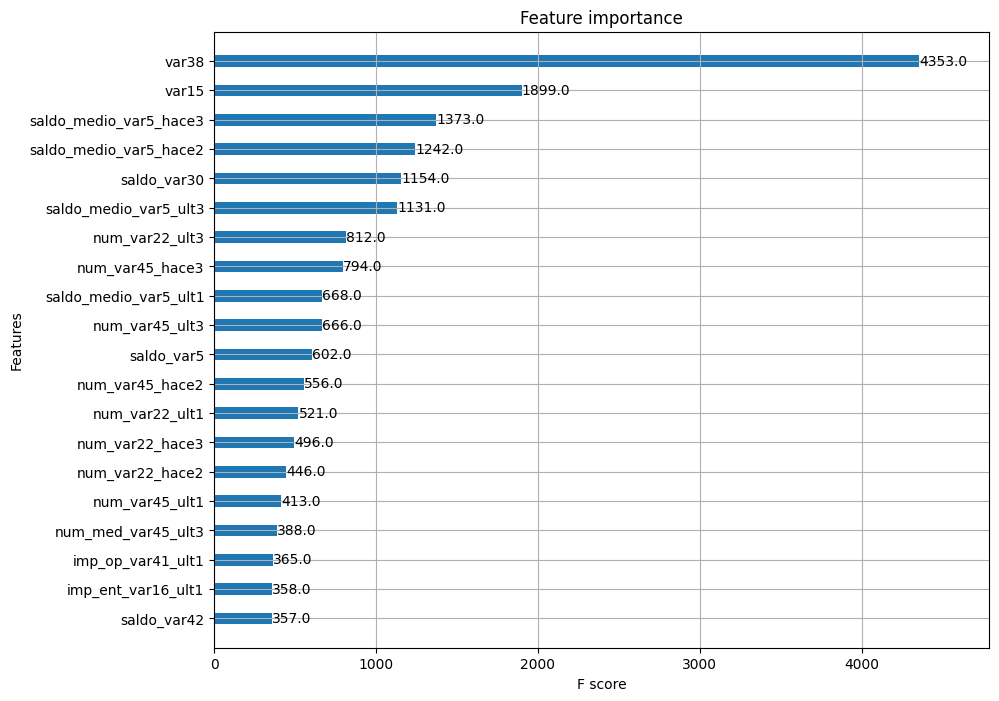

In [13]:
#튜닝된 모델에서 각 피처의 중요도 그래프로 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

##**3) LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

In [1]:
import lightgbm
print(lightgbm.__version__)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


4.5.0


In [2]:
pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [1]:
import lightgbm
print(lightgbm.__version__)

3.3.2


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators=500)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100,eval_metric="auc",
             eval_set=evals, verbose=True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

- XGBoost보다 학습 시간이 조금 단축됨

In [10]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {
    'num_leaves':[32,64],
    'max_depth':[128,160],
    'min_child_samples':[60,100],
    'sub_sample':[0.8,1]
}

#cv는 3으로 지정
gridcv=GridSearchCV(lgbm_clf,param_grid=params,cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30,eval_metric="auc",
           eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridsearchCV 최적 파라미터:',gridcv.best_params_)
lgbm_roc_score=roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's bin

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's bin

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's bin

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's bin

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's bina

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's bi

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binar

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's b

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sub_sample
[1]	training's auc: 0.824305	training's binary_logloss: 0.156217	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.165016
[2]	training's auc: 0.828798	training's binary_logloss: 0.150959	valid_1's auc: 0.822075	valid_1's binary_logloss: 0.159734
[3]	training's auc: 0.839609	training's binary_logloss: 0.147147	valid_1's auc: 0.829436	valid_1's binary_logloss: 0.156119
[4]	training's auc: 0.845158	training's binary_logloss: 0.144107	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.153073
[5]	training's auc: 0.847711	training's binary_logloss: 0.14162	valid_1's auc: 0.839041	valid_1's binary_logloss: 0.150773
[6]	training's auc: 0.849184	training's binary_logloss: 0.139622	valid_1's auc: 0.839076	valid_1's binary_logloss: 0.148948
[7]	training's auc: 0.85094	training's binary_logloss: 0.13786	valid_1's auc: 0.839943	valid_1's binary_logloss: 0.147346
[8]	training's auc: 0.853386	training's binary_logloss: 0.136418	valid_1's auc: 0.84

In [11]:
#해당 하이퍼 파라미터 적용후 다시 학습
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=32,subsample=0.8,
                          min_child_samples=100, max_depth=128)
evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100,eval_metric="auc",
             eval_set=evals, verbose=True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	valid_0's auc: 0.841108	valid_0's binary_logloss: 0

#**2. 캐글 신용카드 사기 검출(4.9장)**

- 해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포
  - 0: 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
  - 1: 신용카드 사기 트랜잭션을 의미
  - 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션

##**1) 언더 샘플링과 오버 샘플링의 이해**

- 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움
- 이를 해결하기 위한 대표적인 방안이 오버 샘플링과 언더 샘플링
- 오버 샘플링이 예측 성능상 더 유리한 경우가 많아 주로 사용


**언더 샘플링**
- 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 수준으로 감소
- 너무 많은 정상 레이블 데이터를 감소 시켜서 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있음

**오버 샘플링**
- 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
- SMOTE: 적은 데이터 세트에 있는 개별 데이터들의 K최근점 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성
  - SMOTE 구현 파이썬 패키지: imbalanced-learn

##**2) 데이터 일차 가공 및 모델 학습/예측/평가**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df=pd.read_csv("/content/drive/MyDrive/Euron7_ML/data/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- V로 시작한 피처는 의미를 알 수 없음
- Time 피터는 큰 의미가 없어서 제거 할 것임
- Amount : 신용카드 트랜잭션 금액
- Class : 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션

In [13]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

In [15]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
  #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy=get_preprocessed_df(df)
  #DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  #train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test=\
  train_test_split(X_features,y_target,test_size=0.3, random_state=0,stratify=y_target)
  #학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

In [16]:
#생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산하여
#비슷하게 분할 됐는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [17]:
#로디스틱 회귀를 이용해 신용 카드 사기 여부 예측
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)

    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [28]:
#3장에서 사용한 get_clf_eval()함수를 이용해 평가 수행
get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85279    16]
 [   65    83]]
정확도: 0.9991, 정밀도: 0.8384, 재현율: 0.5608, F1: 0.6721, AUC: 0.9556


In [29]:
#인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

- 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 갖고 있음. 이에 따라 LGBMClassifier객체 생성 시 boost_from_average=False로 파라미터 설정
- 디폴트는 True임. boost_from_average=True설정은 재형률 및 ROC-AUC 성능을 크게 저하시킴

In [30]:
#모델 학습 후 예측 평가
from lightgbm import LGBMClassifier
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


##**3) 데이터 분포도 변환 후 모델 학습/예측/평가**

<Axes: xlabel='Amount', ylabel='Density'>

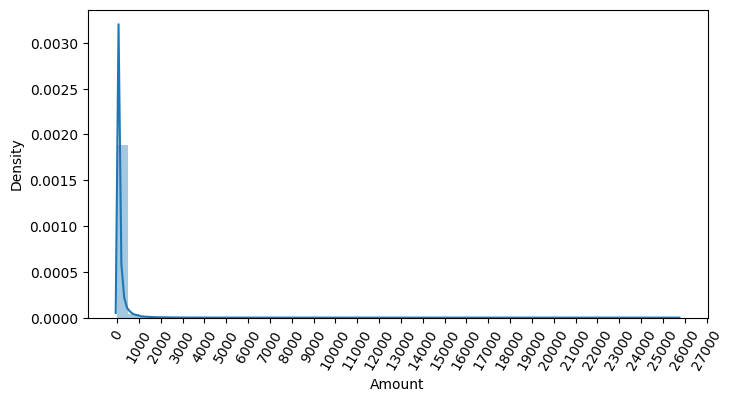

In [31]:
#Amount 피처의 분포도 확인
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])

In [32]:
#Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능 측정
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler= StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  #변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [34]:
#Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능###')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('###LightGBM 예측 성능###')
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1: 0.7294, AUC: 0.9706
###LightGBM 예측 성능###
오차 행렬
[[85191   104]
 [  101    47]]
정확도: 0.9976, 정밀도: 0.3113, 재현율: 0.3176, F1: 0.3144, AUC: 0.6578


In [36]:
#로그 변환은 데이터 분포도가 심하게 왜곡 돼있을 경우 적용하는 기법
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  #넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [37]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('###LightGBM 예측 성능###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1: 0.7120, AUC: 0.9734
###LightGBM 예측 성능###
오차 행렬
[[85268    27]
 [   65    83]]
정확도: 0.9989, 정밀도: 0.7545, 재현율: 0.5608, F1: 0.6434, AUC: 0.7802


##**4) 이상치 데이터 제거 후 모델 학습/예측/평가**

- 이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불림
- 이상치로 인해 ML모델 성능에 영향을 받는 경우가 발생하기 쉬움
- IQR 방식(Inter Quantile Range)
  - 사분위(Quantile)값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot)방식으로 시각화 할 수 있음
  - 사분위는 전체 데이터를 값이 높은 순으로 정렬하고 이를 1/4씩 구간을 분할하는 것을 지칭
-IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주
- 3/4 분위수에 IQR*1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값 가정
- 1/4 분위수에 IQR*1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정
- 매우 많은 피처가 있을 경우 이들 중 결정값(즉 레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋음


<Axes: >

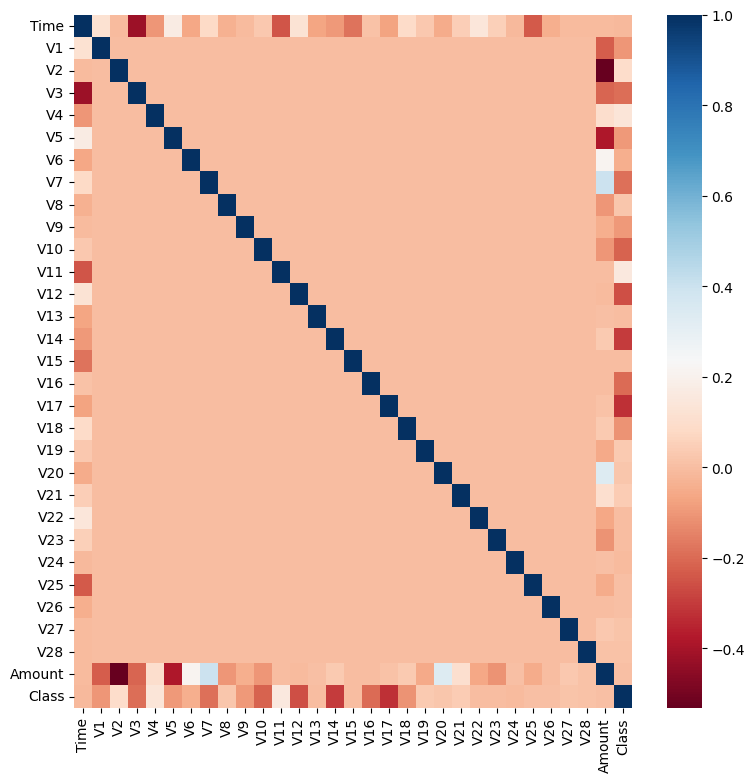

In [38]:
#각 피처별로 상관도를 구한 뒤 시각화
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [40]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  #fraud에 해당하는 column데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile()로 구함
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values, 25)
  quantile_75=np.percentile(fraud.values, 75)
  #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val = quantile_25-iqr_weight
  hightest_val=quantile_75+iqr_weight
  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index=fraud[(fraud<lowest_val)|(fraud>hightest_val)].index
  return outlier_index

In [41]:
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [42]:
#get_processed_df()를 로그로 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  #이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy


In [43]:
X_train, X_test, y_train, y_test =get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('###LightGBM 예측 성능###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1: 0.7568, AUC: 0.9725
###LightGBM 예측 성능###
오차 행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534, F1: 0.7774, AUC: 0.9218


##**5) SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [51]:
lr_clf = LogisticRegression()
#ftr_train과 tgt_train 인자값이 SMOTE증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1: 0.1022, AUC: 0.9736


- 로지스틱 회귀모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어짐

In [52]:
pred_proba =lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 shape:{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n:',pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 shape:(85441, 2)
pred_proba array에서 앞 3개만 샘플로 추출
: [[9.72375370e-01 2.76246297e-02]
 [9.87058661e-01 1.29413395e-02]
 [9.99999495e-01 5.04674663e-07]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[9.72375370e-01 2.76246297e-02 0.00000000e+00]
 [9.87058661e-01 1.29413395e-02 0.00000000e+00]
 [9.99999495e-01 5.04674663e-07 0.00000000e+00]]


In [55]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

#X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


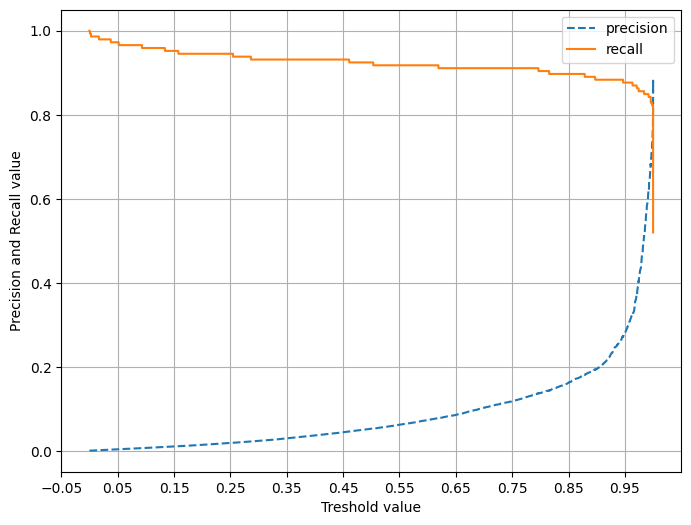

In [63]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [64]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC: 0.9814


- SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적

#**3. Decision Tree And Random Forest Classifier Models(노트북1)**

##**1) 데이터 로드 및 확인**

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [66]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [75]:
data = pd.read_csv("/content/drive/MyDrive/Euron7_ML/data/drug200.csv")

In [76]:
data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [78]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [82]:
age_na_to_k_df = data[['Age', 'Na_to_K']]

correlation = age_na_to_k_df.corr()

print(correlation)

              Age   Na_to_K
Age      1.000000 -0.063119
Na_to_K -0.063119  1.000000


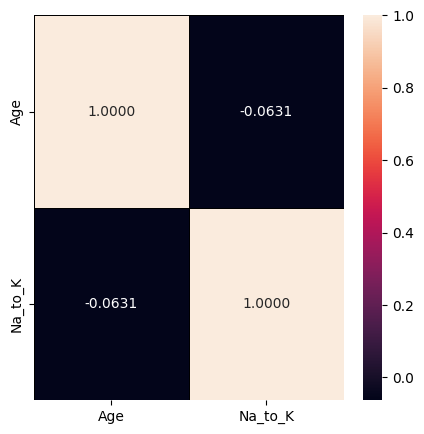

In [84]:
f, ax =plt.subplots(figsize = (5,5))
sns.heatmap(correlation, annot = True,linewidths=0.5, linecolor="black", fmt=".4f",ax=ax)
plt.show()

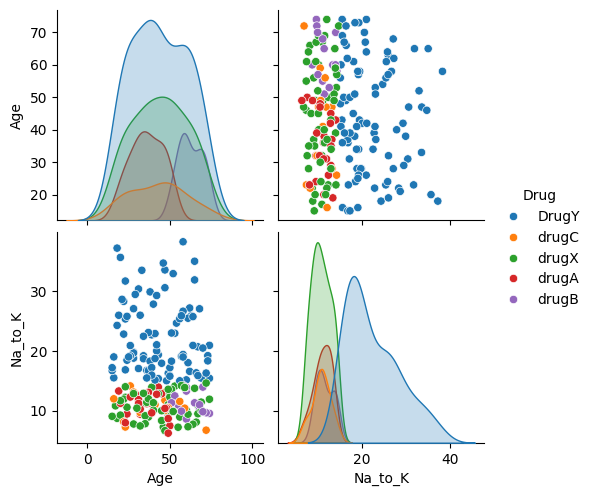

In [85]:
sns.pairplot(data,hue="Drug")

In [86]:
data.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [87]:
data["Age"].value_counts(dropna=False)

,count
Age,
47,8
23,7
28,7
49,7
39,6
32,6
50,5
37,5
58,5


In [89]:
data["Sex"].value_counts()

,count
Sex,
M,104
F,96


In [90]:
data["BP"].value_counts()

,count
BP,
HIGH,77
LOW,64
NORMAL,59


In [91]:
data["Cholesterol"].value_counts()

,count
Cholesterol,
HIGH,103
NORMAL,97


In [92]:
data["Drug"].value_counts()

,count
Drug,
DrugY,91
drugX,54
drugA,23
drugC,16
drugB,16


##**2) 데이터 시각화**

In [93]:
dataAge = data["Age"].value_counts(dropna=False)
npar_dataAge=np.array(dataAge)
x=list(npar_dataAge)
y=data.Age.value_counts().index

DataAge = {"Age":y,"Number":x}
DataAge = pd.DataFrame(DataAge)

fig = px.bar(DataAge, x="Age", y="Number")
fig.show()

In [95]:
colors = ['gold', 'mediumturquoise']
fig = go.Figure(data = [go.Pie(labels= ['M', 'F'], values=[104, 96])])

fig.update_traces(hoverinfo = 'label + percent', textinfo = 'value', textfont_size = 20,
                 marker = dict(colors = colors, line = dict( color = '#000000', width = 2)))

fig.show()


In [97]:
fig = px.bar(x = ["HIGH", "LOW", "NORMAL"], y = [77, 64, 59])

fig.show()

In [98]:
fig = px.histogram(x = ["HIGH", "NORMAL"], y = [103, 97])
fig.show()

In [100]:
fig = go.Figure(data = [go.Pie(labels=["DrugY","DrugX","DrugA","DrugC","DrugB"], values=[91,54,23,16,16])])

fig.update_traces(hoverinfo = 'label + percent', textinfo = 'value', textfont_size = 20,
                 marker = dict(colors = px.colors.sequential.RdBu, line = dict( color = '#000000', width = 2)))

fig.show()

In [101]:
fig = px.scatter(data, x = "Na_to_K", y="Age", color="Drug",
                 size='Age', hover_data=['Na_to_K'])
fig.show()

##**3) 분류 모델들**

###**(1) 데이터 전처리**

In [102]:
dataclass = pd.read_csv("/content/drive/MyDrive/Euron7_ML/data/drug200.csv")

In [103]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [104]:
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [105]:
dataclass.Sex = [1 if i == "F" else 0 for i in dataclass.Sex]

In [106]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,HIGH,HIGH,25.355,DrugY
1,47,0,LOW,HIGH,13.093,drugC
2,47,0,LOW,HIGH,10.114,drugC
3,28,1,NORMAL,HIGH,7.798,drugX
4,61,1,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,LOW,HIGH,11.567,drugC
196,16,0,LOW,HIGH,12.006,drugC
197,52,0,NORMAL,HIGH,9.894,drugX
198,23,0,NORMAL,NORMAL,14.020,drugX


In [107]:
import warnings
warnings.filterwarnings('ignore')

for i in range(0,len(dataclass.BP)):
    if dataclass.BP[i] == "LOW":
        dataclass.BP[i] = 2

    elif dataclass.BP[i] == "NORMAL":
        dataclass.BP[i] = 1

    else:
        dataclass.BP[i] = 0

In [108]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,HIGH,25.355,DrugY
1,47,0,2,HIGH,13.093,drugC
2,47,0,2,HIGH,10.114,drugC
3,28,1,1,HIGH,7.798,drugX
4,61,1,2,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,2,HIGH,11.567,drugC
196,16,0,2,HIGH,12.006,drugC
197,52,0,1,HIGH,9.894,drugX
198,23,0,1,NORMAL,14.020,drugX


In [109]:
dataclass.Cholesterol = [1 if i == "HIGH" else 0 for i in dataclass.Cholesterol]

In [110]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,1,25.355,DrugY
1,47,0,2,1,13.093,drugC
2,47,0,2,1,10.114,drugC
3,28,1,1,1,7.798,drugX
4,61,1,2,1,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,2,1,11.567,drugC
196,16,0,2,1,12.006,drugC
197,52,0,1,1,9.894,drugX
198,23,0,1,0,14.020,drugX


In [111]:
import warnings
warnings.filterwarnings('ignore')

for i in range(0,len(dataclass)):
    if dataclass.Drug[i] == "DrugY":
        dataclass.Drug[i] = 4
    elif dataclass.Drug[i] == "drugX":
        dataclass.Drug[i] = 3
    elif dataclass.Drug[i] == "drugA":
        dataclass.Drug[i] = 2
    elif dataclass.Drug[i] == "drugC":
        dataclass.Drug[i] = 1
    else:
        dataclass.Drug[i] = 0

In [112]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,1,25.355,4
1,47,0,2,1,13.093,1
2,47,0,2,1,10.114,1
3,28,1,1,1,7.798,3
4,61,1,2,1,18.043,4
...,...,...,...,...,...,...
195,56,1,2,1,11.567,1
196,16,0,2,1,12.006,1
197,52,0,1,1,9.894,3
198,23,0,1,0,14.020,3


In [113]:
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 9.5+ KB


In [114]:
data_types_dict = {'BP': int, "Drug": int}

dataclass = dataclass.astype(data_types_dict)

dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    int64  
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 9.5 KB


In [115]:
#x_data
x_data = dataclass.drop(["Drug"], axis = 1)

#y_data
y_data = dataclass.Drug.values

In [116]:
x_data

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,1,0,1,25.355
1,47,0,2,1,13.093
2,47,0,2,1,10.114
3,28,1,1,1,7.798
4,61,1,2,1,18.043
...,...,...,...,...,...
195,56,1,2,1,11.567
196,16,0,2,1,12.006
197,52,0,1,1,9.894
198,23,0,1,0,14.020


In [117]:
y_data

array([4, 1, 1, 3, 4, 3, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 3, 2, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 0, 3, 4, 3, 3, 2, 3, 3, 3, 4, 0, 4, 3,
       3, 3, 2, 1, 4, 4, 4, 3, 4, 4, 0, 1, 0, 4, 3, 4, 4, 2, 4, 3, 0, 4,
       2, 3, 4, 4, 0, 4, 3, 4, 4, 4, 2, 4, 2, 3, 0, 3, 1, 2, 1, 0, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 2, 1, 3, 4, 3, 3, 4, 0, 4,
       2, 3, 3, 3, 3, 4, 3, 3, 2, 4, 4, 4, 4, 4, 0, 4, 4, 3, 4, 3, 4, 4,
       3, 4, 4, 3, 0, 2, 0, 3, 2, 4, 0, 4, 2, 3, 3, 2, 3, 1, 2, 0, 3, 3,
       4, 1, 2, 4, 1, 3, 3, 0, 3, 4, 4, 4, 4, 3, 4, 2, 3, 3, 4, 4, 2, 4,
       2, 4, 4, 4, 4, 3, 3, 4, 4, 4, 0, 2, 4, 4, 4, 2, 4, 1, 4, 1, 1, 3,
       3, 3])

In [118]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

###**(2) Decision Tree Classifier**

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dtc = DecisionTreeClassifier()

# 훈련
dtc.fit(x_train, y_train)

# 예측
predict = dtc.predict(x_test)

print('The accuracy of the Decision Tree is',metrics.accuracy_score(predict,y_test))

The accuracy of the Decision Tree is 0.9666666666666667


Decision Tree Classifier with "gini"

In [120]:
DTC_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# 훈련
DTC_gini.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [121]:
y_pred_gini = DTC_gini.predict(x_test)

In [122]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.9000


In [123]:
y_pred_train_gini = DTC_gini.predict(x_train)

y_pred_train_gini

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 3, 3, 2, 3, 4, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 0, 0, 2, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 3, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 2, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [124]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.9143


In [125]:
print('Training set score: {:.4f}'.format(DTC_gini.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(DTC_gini.score(x_test, y_test)))

Training set score: 0.9143
Test set score: 0.9000


Decision Tree Classifier with "entropy"

In [126]:
DTC_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


#모델 훈련
DTC_en.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [127]:
y_pred_en = DTC_en.predict(x_test)

In [128]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.9000


In [129]:
y_pred_train_en = DTC_en.predict(x_train)

y_pred_train_en

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 3, 3, 2, 3, 4, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 0, 0, 2, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 3, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 2, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [130]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 0.9143


In [131]:
print('Training set score: {:.4f}'.format(DTC_en.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(DTC_en.score(x_test, y_test)))

Training set score: 0.9143
Test set score: 0.9000


###**(3) Random Forest Classifier**

In [132]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 0)

#훈련
rfc.fit(x_train, y_train)

#예측
predict = rfc.predict(x_test)

print('The accuracy of the Random Forest is',metrics.accuracy_score(predict,y_test))

The accuracy of the Random Forest is 0.95


In [133]:
from sklearn.ensemble import RandomForestClassifier

rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

#훈련
rfc_100.fit(x_train, y_train)

#예측
predict = rfc_100.predict(x_test)

print('The accuracy of the Random Forest is',metrics.accuracy_score(predict,y_test))

The accuracy of the Random Forest is 0.95


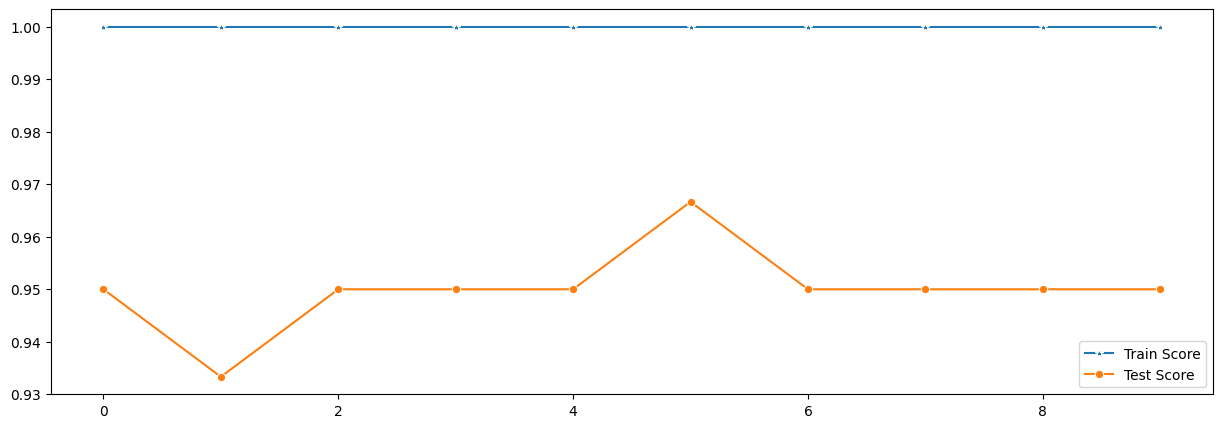

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

test_score_list = []
train_score_list = []

for i in range(0, 10):
    rfc2 = RandomForestClassifier(random_state=i)
    rfc2.fit(x_train, y_train)
    test_score_list.append(rfc2.score(x_test, y_test))
    train_score_list.append(rfc2.score(x_train, y_train))

# 시각화
plt.figure(figsize=(15, 5))
sns.lineplot(x=range(0, 10), y=train_score_list, marker='*', label='Train Score')
sns.lineplot(x=range(0, 10), y=test_score_list, marker='o', label='Test Score')

plt.legend()
plt.show()


최적의 random_state value는 5일 때

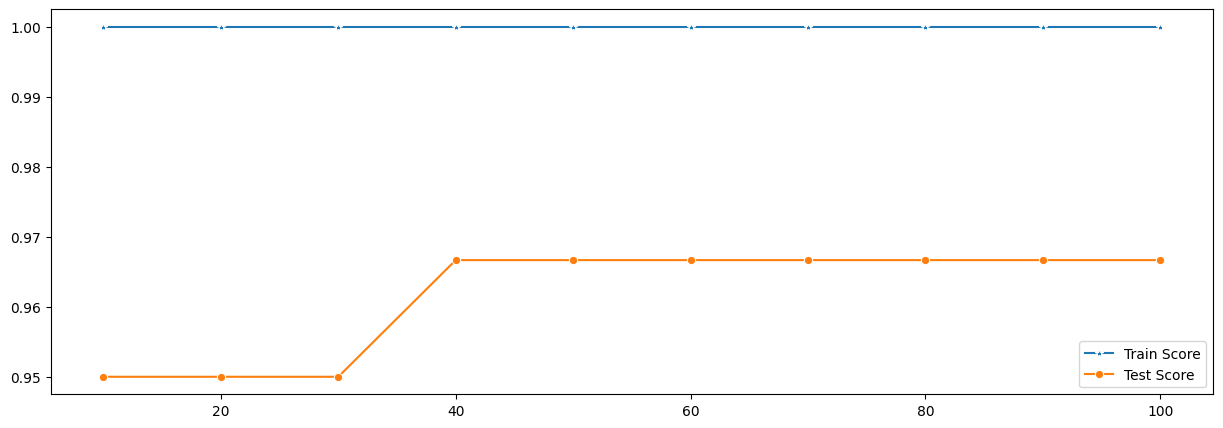

In [141]:
test_score_list = []
train_score_list = []

# n_estimators 리스트
list_n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for n in list_n_estimators:
    rfc3 = RandomForestClassifier(n_estimators=n, random_state=5)
    rfc3.fit(x_train, y_train)
    test_score_list.append(rfc3.score(x_test, y_test))
    train_score_list.append(rfc3.score(x_train, y_train))

# 시각화
plt.figure(figsize=(15, 5))
sns.lineplot(x=list_n_estimators, y=train_score_list, marker='*', label='Train Score')
sns.lineplot(x=list_n_estimators, y=test_score_list, marker='o', label='Test Score')

plt.legend()
plt.show()


최적의 파라미터들로 Random Forest Classifier

In [142]:
last_rfc = RandomForestClassifier(n_estimators=100, random_state=5)

# fit the model
last_rfc.fit(x_train,y_train)

predict = last_rfc.predict(x_test)

print('The accuracy of the Random Forest is',metrics.accuracy_score(predict,y_test))

The accuracy of the Random Forest is 0.9666666666666667


In [143]:
y_pred_en = last_rfc.predict(x_test)

In [144]:
print('Model accuracy score with best parameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with best parameters: 0.9667


In [145]:
y_pred_train_en = last_rfc.predict(x_train)

y_pred_train_en

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 1, 4, 1, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 1, 3, 2, 3, 4, 2, 0, 0, 3, 3, 1, 3, 3, 4, 4, 4, 4, 3,
       1, 0, 0, 2, 4, 3, 4, 1, 4, 4, 1, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 1, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 2, 3, 1, 1, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [146]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 1.0000


In [147]:
print('Training set score: {:.4f}'.format(last_rfc.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(last_rfc.score(x_test, y_test)))

Training set score: 1.0000
Test set score: 0.9667


###**(4) Evaluation Classification Models**

####**confusion matrix**

In [148]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cm_des = DecisionTreeClassifier()

cm_des.fit(x_train,y_train)

y_pred_cm = cm_des.predict(x_test)
y_true = y_test

cm_des1 = confusion_matrix( y_true, y_pred_cm)
cm_des1

array([[ 4,  0,  2,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

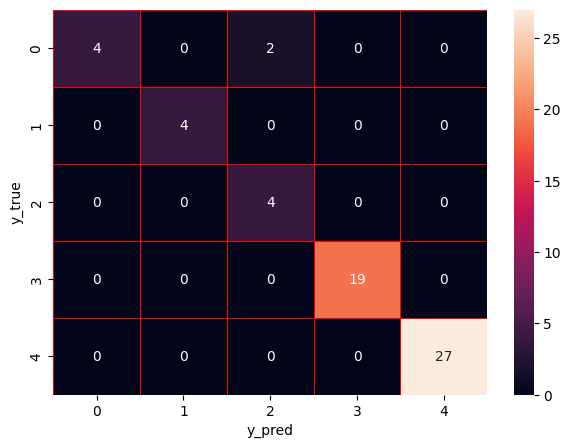

In [149]:
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(cm_des1, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Confusion Matrix For Decision Tree Classifier With "gini"

In [150]:
cm_des_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

cm_des_gini.fit(x_train,y_train)

y_pred_cm = cm_des_gini.predict(x_test)
y_true = y_test

cm_des2 = confusion_matrix( y_true, y_pred_cm)
cm_des2

array([[ 4,  0,  2,  0,  0],
       [ 0,  0,  0,  4,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

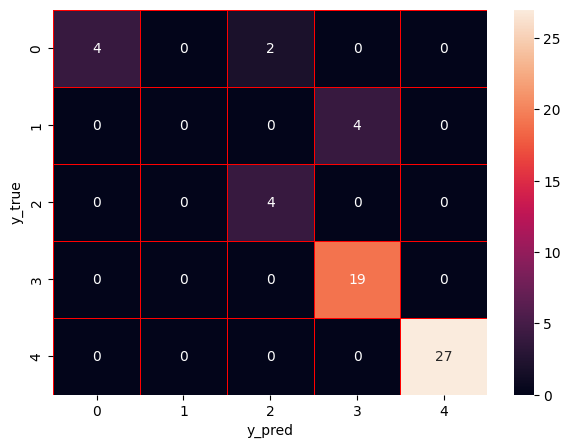

In [151]:
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(cm_des2, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Confusion Matrix For Random Forest Classifier With The Best Parameters

In [153]:
cm_last_rfc = RandomForestClassifier(n_estimators=100, random_state=5)

cm_last_rfc.fit(x_train, y_train)

y_pred_cm = cm_last_rfc.predict(x_test)
y_true = y_test

cm_rfc = confusion_matrix(y_true, y_pred_cm)
cm_rfc

array([[ 4,  0,  2,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

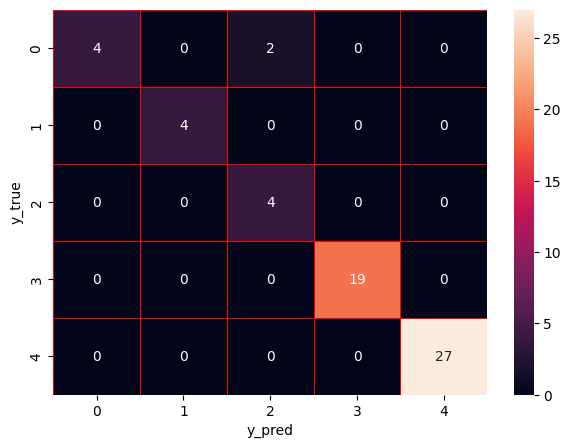

In [154]:
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(cm_rfc, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#**4. Beginner Friendly CatBoost with Optuna(노트북2)**

In [158]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [160]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


##**1) 데이터 분석**

####**라이브러리 임포트**

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

#importing plotly and cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(offline=True, world_readable=True)

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"

from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [165]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',900)

pd.set_option('display.max_colwidth',200)

df = pd.read_csv('/content/drive/MyDrive/Euron7_ML/data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [166]:
df.duplicated().sum()

0

In [167]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [168]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [169]:
df[categorical].nunique()

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


####**타겟 변수**

In [173]:
y = df['HeartDisease']
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

Percentage of patient had a HeartDisease:  55.34 %  --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66  %  --> (410 patient)


- 약 55%가 심장병

In [175]:
df['HeartDisease'].iplot(kind='hist')

####**Numerical Features**

In [176]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [177]:
df[numerical].iplot(kind='hist')

In [178]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

In [179]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].drop('FastingBS', axis=1).skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

,0
Oldpeak,1.022872


<Axes: >

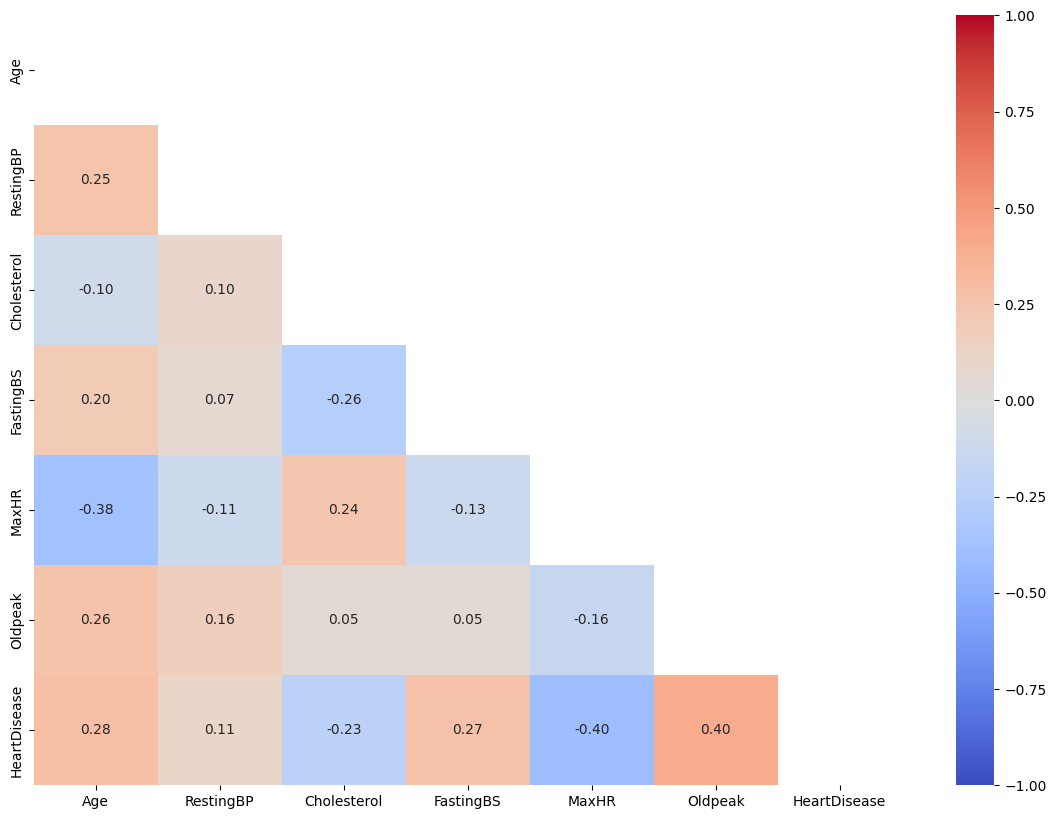

In [180]:
numerical1= df.select_dtypes('number').columns


matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap (df[numerical1].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax)

- Oldpeak가 심장병과 양의 상관관계

####**Categorical Features**

In [181]:
df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [182]:
print (f'A female person has a probability of {round(df[df["Sex"]=="F"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

print()

print (f'A male person has a probability of {round(df[df["Sex"]=="M"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

print()

A female person has a probability of 25.91 % have a HeartDisease

A male person has a probability of 63.17 % have a HeartDisease



In [183]:
fig = px.histogram(df, x="Sex", color="HeartDisease",width=400, height=400)
fig.show()

- 남자가 여자보다 2.44배 더 많이 심장병을 가질 확률이 높다

In [185]:
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ChestPainType,
ASY,0.790323
TA,0.434783
NAP,0.354680
ATA,0.138728


In [186]:
fig = px.histogram(df, x="ChestPainType", color="HeartDisease",width=400, height=400)
fig.show()

- ASY타입의 사람은 다른 타입보다 심장병을 6배나 더 많이 갖고 있다.

In [187]:
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
RestingECG,
ST,0.657303
LVH,0.563830
Normal,0.516304


In [188]:
fig = px.histogram(df, x="RestingECG", color="HeartDisease",width=400, height=400)
fig.show()

In [189]:
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ExerciseAngina,
Y,0.851752
N,0.351005


In [190]:
fig = px.histogram(df, x="ExerciseAngina", color="HeartDisease",width=400, height=400)
fig.show()

- Yes인 사람이 No인 사람보다 심장병을 가질 가능성이 2.4배 높다.

In [191]:
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ST_Slope,
Flat,0.828261
Down,0.777778
Up,0.197468


In [192]:
fig = px.histogram(df, x="ST_Slope", color="HeartDisease",width=400, height=400)
fig.show()


##**MODEL SELECTION**

####**Baseline Model**

In [194]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')


model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


####**Logistic & Linear Discriminant & SVC & KNN**

In [195]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')


lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','LinearDiscriminant','SVM','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8841
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.7246
model : KNeighborsClassifier() and  accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


####**Logistic & Linear Discriminant & SVC & KNN with Scaler**

In [196]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
s= StandardScaler()
ct1= make_column_transformer((ohe,categorical),(s,numerical))


lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models:
    pipe = make_pipeline(ct1, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_scl','LinearDiscriminant_scl','SVM_scl','KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8804
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.8841
model : KNeighborsClassifier() and  accuracy score is : 0.8841


,Accuracy
Logistic_scl,0.8804
LinearDiscriminant_scl,0.8696
SVM_scl,0.8841
KNeighbors_scl,0.8841


####**Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)**

In [197]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')

ada = AdaBoostClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
et=  ExtraTreesClassifier(random_state=0)

models = [ada,gb,rf,et]

for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada','Gradient','Random','ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.8659
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.8768
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.8877
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.8804


,Accuracy
Ada,0.8659
Gradient,0.8768
Random,0.8877
ExtraTree,0.8804


- 하이퍼파라미터 튜닝으로 모델 향상시키기

####**Famous Trio (XGBoost & LightGBM & Catboost**)

In [198]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')

xgbc = XGBClassifier(random_state=0)
lgbmc=LGBMClassifier(random_state=0)

models = [xgbc,lgbmc]

for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost','LightGBM']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

,Accuracy
XGBoost,0.8478
LightGBM,0.8732


####**CATBOOST**

In [199]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df5

,Accuracy
Catboost_default,0.8804


####**Catboost HyperParameter Tuning with Optuna**

In [201]:
def objective(trial):
    X= df.drop('HeartDisease', axis=1)
    y= df['HeartDisease']
    categorical_features_indices = np.where(X.dtypes != float)[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-11-04 13:30:03,566] A new study created in memory with name: no-name-75a80adc-3f73-400d-b448-b590c0ce859f
[I 2024-11-04 13:30:11,899] Trial 0 finished with value: 0.8876811594202898 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08862986327584872, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.579168557044547}. Best is trial 0 with value: 0.8876811594202898.
[I 2024-11-04 13:30:17,232] Trial 1 finished with value: 0.894927536231884 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.025905072670596073, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.894927536231884.
[I 2024-11-04 13:30:21,459] Trial 2 finished with value: 0.8913043478260869 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09857460962707136, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7237772146120902}. Best is trial 1 with 

Number of finished trials: 50
Best trial:
  Value: 0.9057971014492754
  Params: 
    objective: Logloss
    colsample_bylevel: 0.04142526508648657
    depth: 10
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 4.598502159265359


- 새 파라미터로 최적의 모델 생

In [203]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0,
                          objective= 'CrossEntropy',
    colsample_bylevel= 0.04292240490294766,
    depth= 10,
    boosting_type= 'Plain',
    bootstrap_type= 'MVS')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.91      0.91       276
weighted avg       0.91      0.91      0.91       276



,Accuracy
Catboost_tuned,0.9094


In [204]:
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

In [205]:
result_final = pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)

In [206]:
result_final.sort_values(by=['Accuracy'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Accuracy', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
fig.show()